# Notebook for simulating, saving and analysing MOMA-like data for a parameter range

In [1]:
from cells_simulation import *


In [6]:

def growth_2OUs(cell, dt, lt1, lt2):  
    # calculate next step
    lt = lt1+lt2
    next_step = cell.log_length[-1] + lt*dt

    cell.log_length.append(next_step)
    cell.length.append(np.exp(next_step))
    return cell

def simulate_cells_2OUs(dt, n_cells, 
                        parameter_set, 
                        div_mode, 
                        division_log_length=None, 
                        division_time=None,
                        division_addition=None,
                        tree =True,
                        tmax=np.inf):
    gfp0 = 3*parameter_set['mean_q']/parameter_set['mean_lambda']
    cell = Cell(division_log_length-np.log(2), gfp0, parameter_set['mean_lambda'], parameter_set['mean_q'])

    cell.lt1 = [parameter_set['mean_lambda']]
    cell.lt2 = [parameter_set['mean_lambda_2']]


    cell_queue = [cell]
    cells_simulated = []
    no_cells = 0   # total number of cells (in queue and calculated)
    t_total = 0    # the largest t in the current set of cells


    while len(cells_simulated) < n_cells and t_total < tmax:
        if len(cells_simulated)>0:
            idx = get_current_leafs_idx(cell_queue, cells_simulated)
            cell_index = np.random.choice(idx)
        else:
            cell_index = 0

        cell = copy.deepcopy(cell_queue[cell_index])

        # --------------------------------------------------------------- #
        # Simulation on single cell level
        # --------------------------------------------------------------- #
        while True:
            cell.time.append(cell.time[-1]+dt)

            t_total = np.max([t_total, cell.time[-1]])
            if t_total > tmax:
                break

            q_ou = single_ou_step(dt,   parameter_set['mean_q'], 
                                        parameter_set['gamma_q'], 
                                        parameter_set['var_q'], 
                                        cell.qt[-1]) 

            cell = gfp_production(cell, dt, q_ou, parameter_set['beta'])

            lambda_ou1 = single_ou_step(dt,  parameter_set['mean_lambda'], 
                                            parameter_set['gamma_lambda'], 
                                            parameter_set['var_lambda'], 
                                            cell.lt1[-1]) 

            lambda_ou2 = single_ou_step(dt,  parameter_set['mean_lambda_2'], 
                                            parameter_set['gamma_lambda_2'], 
                                            parameter_set['var_lambda_2'], 
                                            cell.lt2[-1]) 

            cell = growth_2OUs(cell, dt, lambda_ou1, lambda_ou2)

            # save everything
            cell.lt1.append(lambda_ou1)
            cell.lt2.append(lambda_ou2)

            if is_cell_division(cell, div_mode, division_log_length, division_time, division_addition):
                # calc. new init conditions for 2 daugter cells
                cell1, cell2, no_cells = cell_divsion(cell, parameter_set['var_dx'], 
                                                            parameter_set['var_dg'], 
                                                            no_cells)
                cell1.lt1=[cell.lt1[-1]]
                cell2.lt1=[cell.lt1[-1]]
                
                cell1.lt2=[cell.lt2[-1]]
                cell2.lt2=[cell.lt2[-1]]

                # save the simulated cell
                cell.lt = np.array(cell.lt1) + np.array(cell.lt2)
                cells_simulated.append(cell)
                
                # remove the simulated cell from queue and add the new ones 
                cell_queue.pop(cell_index)
                cell_queue.append(cell1)
                if tree:
                    cell_queue.append(cell2)
                break
            else:
                pass
        progress_bar_n = np.around(len(cells_simulated)/n_cells*20).astype(int)
        progress_bar = '='*progress_bar_n + ' '*(20-progress_bar_n)

        print("\r|", progress_bar,  "| Progress {:3.0f}%".format(len(cells_simulated)/n_cells*100), " No of cells: ", len(cells_simulated), end='')  
    print('')
    return cells_simulated

def ou_variance(gamma, var, t1, t0=0):
    t = np.array(t1)
    return var/(2*gamma) * ( 1 - np.exp(-2*gamma*(t-t0)) )

class Cell:
    def __init__(self, log_length0, gfp0, lambda0, q0, time0=0., cell_id = 0, parent_id=-1):
        self.parent_id = parent_id
        self.cell_id = cell_id
        self.length = [np.exp(log_length0)]  # s(t)
        self.log_length = [log_length0]      # x(t) = x0 + int lambda dt
        self.gfp = [gfp0]
        self.lt = [lambda0]
        self.qt = [q0]
        self.time = [time0]

    def to_df(self, n=1):
        return pd.DataFrame({   "cell_id": ([self.cell_id]*len(self.time))[::n],
                                "time_min": self.time[::n],
                                "parent_id": ([self.parent_id]*len(self.time))[::n],
                                "log_length": self.log_length[::n], 
                                "gfp": self.gfp[::n],
                                "lt1": self.lt1[::n],
                                "lt2": self.lt2[::n],
                                "lt": self.lt[::n],
                                "qt": self.qt[::n]})

In [7]:
def write_csv_config(filename):
    with open(filename, "w") as fin:
        fin.write("# Generated config file for simulated data\n")
        fin.write("time_col = time_min  \n")
        fin.write("length_col = log_length_noise \n")
        fin.write("length_islog = true \n")
        fin.write("fp_col = gfp_noise \n")
        fin.write("parent_tags = parent_id \n")
        fin.write("cell_tags = cell_id \n")
        fin.write("rescale_time = 1 \n")

In [8]:
# ========== Simulation parameters ========== #
save_dataset = True    # saves data set as csv
run_ggp = True         # runs the ggp code (located in "../bin/" relative to this nb)

dt = 1e-2
dt_measument = 3 # in minutes
n_cells = 250 # number of cells that will be simulated

div_mode = "sizer"

division_log_length = 1+np.log(2)   # for sizer: division, when log_length hits division_log_length
division_time = 60                  # for timer: division, when cell cycle time hits division_time
division_addition = np.log(2)       # for adder: divsion, when division_addition in log_length was added in cell cycle


In [9]:

param_range = np.geomspace(0.001, 1, 20)[:]
# param_range = np.geomspace(0.07, 0.2, 20)[:]

print(*param_range, "\n")

out_dir = mk_mising_dir('../data_2.0/test_2OUs_const_var_gamma_n{:d}_{:s}'.format(n_cells, div_mode))

for gamma_lambda_2 in param_range:
    # ========== Model parameters ========== #
    parameter_set = {   "mean_lambda": 0.01, 
                        "mean_lambda_2": 0.0, 
                        "gamma_lambda": 0.1,
                        "gamma_lambda_2": gamma_lambda_2,
                        "var_lambda": 1e-7,
                        "var_lambda_2": None,
                        "mean_q": 10,
                        "gamma_q": 1e-2,
                        "var_q": 0.1,
                        "beta": 1e-3,
                        "var_x": 1e-3, # 1e-3,
                        "var_g": 5000, # 5000,
                        "var_dx": 0.001,
                        "var_dg": 500}

    parameter_set["var_lambda_2"] = parameter_set["var_lambda"] * gamma_lambda_2 /parameter_set["gamma_lambda"]
    
    # --------- SIMULATE --------- #
    cells_simulated = simulate_cells_2OUs(dt, n_cells, parameter_set, div_mode,
                            division_log_length, 
                            division_time, 
                            division_addition, tree=False)

    dataset = build_data_set(cells_simulated, parameter_set['var_x'], parameter_set['var_g'], int(dt_measument/dt))

    # ----------- SAVE ----------- #
    if save_dataset:
        directory, filename = get_next_file_name(out_dir)

        write_param_file(os.path.join(directory, "parameters.txt"), parameter_set) 

        write_csv_config(os.path.join(directory, "csv_config.txt"))
        dataset.to_csv(filename)
        print("New simulation saved in", filename)

        # ----------- RUN ----------- #
        if run_ggp:
            run_cmd = suggest_run_command(directory, filename, modes="-m -p", t=5e-2, add_flag = '-space log')
            print("run: -> \n", run_cmd)
            s = subprocess.run(run_cmd, capture_output=False, shell=True)
            print(s)

0.001 0.0014384498882876629 0.00206913808111479 0.002976351441631319 0.004281332398719396 0.006158482110660267 0.008858667904100823 0.012742749857031334 0.018329807108324356 0.026366508987303583 0.0379269019073225 0.05455594781168517 0.07847599703514611 0.11288378916846883 0.1623776739188721 0.23357214690901212 0.3359818286283781 0.4832930238571752 0.6951927961775606 1.0 

| ==================== | Progress 100%  No of cells:  250
Every 300 th datapoint is saved
None
New simulation saved in ../data_2.0/test_2OUs_const_var_gamma_n250_sizer/test_2OUs_const_var_gamma_n250_sizer_0/test_2OUs_const_var_gamma_n250_sizer_0.csv
run: -> 
 ../bin/gfp_gaussian -c ../data_2.0/test_2OUs_const_var_gamma_n250_sizer/test_2OUs_const_var_gamma_n250_sizer_0/csv_config.txt -b ../data_2.0/test_2OUs_const_var_gamma_n250_sizer/test_2OUs_const_var_gamma_n250_sizer_0/parameters.txt -t 0.05 -i ../data_2.0/test_2OUs_const_var_gamma_n250_sizer/test_2OUs_const_var_gamma_n250_sizer_0/test_2OUs_const_var_gamma_n250_si

In [27]:

# =============== PLOT =============== #
def plot_cells(cells, n_steps=1):
    _, axes = plt.subplots(2, figsize=(5,4))
    ax = axes.ravel()

    for j in range(len(cells[::n_steps])):
        cell = copy.deepcopy(cells[j])
        cell.time = np.array(cell.time)

        if n_steps>1:
            ax[0].set_title("log length (showing every {:d}th cell)".format(n_steps))
            ax[1].set_title("gfp (showing every {:d}th cell)".format(n_steps))

        else:
            ax[0].set_title("log length")
            ax[1].set_title("gfp")

        # ax[0].set_ylim([1.2, 2.2])
        
        if len(cells[::n_steps]) <20:
            ax[0].axvline(cell.time[-1], ls='--', color='tab:blue')
            ax[1].axvline(cell.time[-1], ls='--', color='tab:orange')

        if j ==0:
            ax[0].plot(cell.time, np.array(cell.log_length), label='log length', color='tab:blue')
            ax[1].plot(cell.time, np.array(cell.gfp), color='tab:orange', label='gfp')

        else:
            ax[0].plot(cell.time, np.array(cell.log_length), color='tab:blue')
            ax[1].plot(cell.time, np.array(cell.gfp), color='tab:orange')

    for j in range(2):
        ax[j].legend()
    plt.tight_layout()
    plt.show()


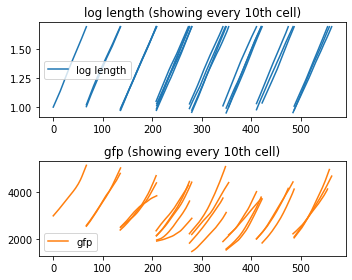

In [29]:
plot_cells(cells_simulated, n_steps=10)

In [24]:
cell_sparse = df2cells(dataset)

In [25]:

# =============== PLOT =============== #
def plot_cells_scatter(cells, n_steps=1):
    _, axes = plt.subplots(2, figsize=(5,4))
    ax = axes.ravel()

    for j in range(len(cells[::n_steps])):
        cell = copy.deepcopy(cells[j])
        cell.time = np.array(cell.time)

        if n_steps>1:
            ax[0].set_title("log length (showing every {:d}th cell)".format(n_steps))
            ax[1].set_title("gfp (showing every {:d}th cell)".format(n_steps))

        else:
            ax[0].set_title("log length")
            ax[1].set_title("gfp")

        # ax[0].set_ylim([1.2, 2.2])
        s=2
        if j ==0:
            ax[0].scatter(cell.time, np.array(cell.log_length), label='log length', color='tab:blue',s=s)
            ax[1].scatter(cell.time, np.array(cell.gfp), color='tab:orange', label='gfp',s=s)

        else:
            ax[0].scatter(cell.time, np.array(cell.log_length), color='tab:blue', s=s)
            ax[1].scatter(cell.time, np.array(cell.gfp), color='tab:orange', s=s)

    for j in range(2):
        ax[j].legend()
    plt.tight_layout()

    plt.show()

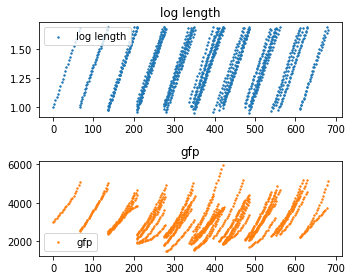

In [30]:
plot_cells_scatter(cell_sparse[:50], n_steps=1)
